# Bot de inversion para cripto

In [1]:
#!pip install yfinance
#!pip install mpl_finance
#!pip install python-binance
#!pip3 install plotly

## import dependencies

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from datetime import date
from datetime import timedelta
import plotly.graph_objects as go
from binance import Client
from config import API_Key,Secret_Key
import os

## Gathering data with binance api

In [3]:
client = Client(API_Key, Secret_Key)

In [4]:
# get historical kline data from any date range
#BTCOIN USDOLAR PRICE
#first currency and crypto,then time interval, and time to go back
# arguments of function have to be strings


def get_crypto_data(crypto, interval, lookback):
    Crypto_df = pd.DataFrame(client.get_historical_klines(crypto, interval, lookback + ' ago UTC'))
    
   # show only first 5 columns
    Crypto_df = Crypto_df.iloc[:,:6]
    #naming columns
    Crypto_df.columns = ['Date_and_Time','Open', 'High', 'Low','Last','Volume']
    # from the complete data, set index to date
#     Crypto_df = Crypto_df.\
#     set_index(pd.DatetimeIndex(Crypto_df['Date'].values))
#     Crypto_df.tail()
    Crypto_df = Crypto_df.set_index('Date_and_Time')
    Crypto_df.index = pd.to_datetime(Crypto_df.index, unit='ms')
#     Crypto_df.tz_localize('UTC').tz_convert('Mexico/General')
    

   # all values are stored as string so change them into float.
    Crypto_df = Crypto_df.astype(float)
    return Crypto_df

## Creating historical data : crypto df

In [5]:
lookback = '6 months'
crypto_df= get_crypto_data('BTCUSDT', '30m', lookback).tz_localize('UTC').tz_convert('Mexico/General')
crypto_df.shape

(8819, 5)

In [6]:
crypto_df.tail(10)

,Open,High,Low,Last,Volume
Date_and_Time,,,,,
2021-11-24 12:30:00-06:00,56963.03,56991.56,56650.00,56799.99,564.39285
2021-11-24 13:00:00-06:00,56799.98,56870.01,56571.42,56733.26,575.47804
2021-11-24 13:30:00-06:00,56733.27,56893.00,56679.90,56825.13,624.23852
2021-11-24 14:00:00-06:00,56825.13,57184.22,56722.00,57116.86,831.40407
2021-11-24 14:30:00-06:00,57116.86,57429.00,56925.06,57388.78,1167.58777
2021-11-24 15:00:00-06:00,57388.78,57476.03,57180.00,57245.00,920.04422
2021-11-24 15:30:00-06:00,57244.99,57434.30,57242.89,57308.82,598.75182
2021-11-24 16:00:00-06:00,57308.82,57450.00,57099.17,57176.76,576.63674
2021-11-24 16:30:00-06:00,57176.76,57193.40,56833.00,56989.83,649.85640


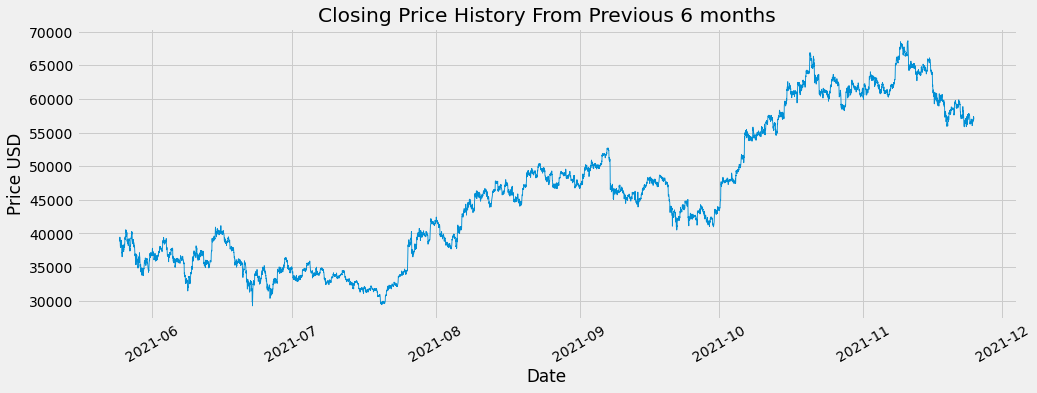

In [7]:
# plot prices
plt.figure(figsize=(15, 5))
plt.plot(crypto_df['Last'],label='closing price', linewidth = 0.9)
plt.title(f'Closing Price History From Previous {lookback}')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.xticks(rotation=30)
plt.show()

## historical price w plotly to html

In [8]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')
fig = go.Figure(data=[go.Candlestick(x=crypto_df.index,
                open=crypto_df['Open'],
                high=crypto_df['High'],
                low=crypto_df['Low'],
                close=crypto_df['Last'])])
fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()
fig.write_html(f'{path}/historical.html')


# code machine larning: Linear regresion and tecnical indicators and forward testing

In [9]:
# showing only BTC price
crypto_last_price_df = crypto_df[['Last']]
crypto_last_price_df.head(16)

,Last
Date_and_Time,
2021-05-24 18:30:00-05:00,38796.29
2021-05-24 19:00:00-05:00,39447.37
2021-05-24 19:30:00-05:00,39387.52
2021-05-24 20:00:00-05:00,38999.96
2021-05-24 20:30:00-05:00,38808.30
2021-05-24 21:00:00-05:00,38298.28
2021-05-24 21:30:00-05:00,38083.69
2021-05-24 22:00:00-05:00,38242.40
2021-05-24 22:30:00-05:00,38304.51


In [10]:
#  variable for predicting x number of periods into the future
predict_periods = 16 #numer of periods, then change this info to function

# create another column shifted n units up
crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)

<ipython-input-10-91f82b2f9c00>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
# show df with new column
crypto_last_price_df.head(16)

,Last,Prediction
Date_and_Time,,
2021-05-24 18:30:00-05:00,38796.29,38985.06
2021-05-24 19:00:00-05:00,39447.37,38538.84
2021-05-24 19:30:00-05:00,39387.52,38138.06
2021-05-24 20:00:00-05:00,38999.96,37981.81
2021-05-24 20:30:00-05:00,38808.30,37932.87
2021-05-24 21:00:00-05:00,38298.28,37230.39
2021-05-24 21:30:00-05:00,38083.69,37103.24
2021-05-24 22:00:00-05:00,38242.40,37148.01
2021-05-24 22:30:00-05:00,38304.51,36537.16


In [12]:
# show last 15 rows of new dataset
crypto_last_price_df.tail(17)

,Last,Prediction
Date_and_Time,,
2021-11-24 09:00:00-06:00,56292.99,57023.97
2021-11-24 09:30:00-06:00,56727.53,NaN
2021-11-24 10:00:00-06:00,56631.34,NaN
2021-11-24 10:30:00-06:00,56608.82,NaN
2021-11-24 11:00:00-06:00,56557.10,NaN
2021-11-24 11:30:00-06:00,56546.03,NaN
2021-11-24 12:00:00-06:00,56963.03,NaN
2021-11-24 12:30:00-06:00,56799.99,NaN
2021-11-24 13:00:00-06:00,56733.26,NaN


In [13]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(crypto_last_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_periods]
print(a)

[[38796.29]
 [39447.37]
 [39387.52]
 ...
 [56088.52]
 [56134.95]
 [56292.99]]


In [14]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = crypto_last_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_periods]
print(b)

[38985.06 38538.84 38138.06 ... 57176.76 56989.83 57023.97]


In [15]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [16]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

## linear regression similarity

In [17]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: 0.8790430027970891


In [18]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(crypto_last_price_df[['Last']])[-predict_periods:]
print(a_projection)

[[56727.53]
 [56631.34]
 [56608.82]
 [56557.1 ]
 [56546.03]
 [56963.03]
 [56799.99]
 [56733.26]
 [56825.13]
 [57116.86]
 [57388.78]
 [57245.  ]
 [57308.82]
 [57176.76]
 [56989.83]
 [57023.97]]


In [19]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[56742.17777808 56646.20202253 56623.73218144 56572.12737764
 56561.08203391 56977.15324779 56814.47638757 56747.89501562
 56839.56039313 57130.64062149 57401.95497276 57258.49521465
 57322.17306805 57190.40720593 57003.89355602 57037.95751583]


## price results with machine learning prediction

In [20]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual_price', 'predicted_price'])

previously_predicted = results_df[['predicted_price']]

date = datetime.now().strftime("%Y_%m_%d_%I_%M_%S_%p")
previously_predicted.to_csv(f'Resources/previous_predicted_price_{date}.csv') 

pwd = os.getcwd()
path = os.path.join(pwd,'Resources')
entries = os.listdir(path)

price_results_df = pd.concat([results_df, pd.read_csv('Resources/'+ entries[-2])], axis =1)
price_results_df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
price_results_df.columns = ['actual_price', 'predicted_price', 
                                            'previously_predicted_price']
price_results_df = price_results_df.astype(float)
price_results_df.head(17)

,actual_price,predicted_price,previously_predicted_price
0,56727.53,56742.177778,56742.177778
1,56631.34,56646.202023,56646.202023
2,56608.82,56623.732181,56623.732181
3,56557.10,56572.127378,56572.127378
4,56546.03,56561.082034,56561.082034
5,56963.03,56977.153248,56977.153248
6,56799.99,56814.476388,56814.476388
7,56733.26,56747.895016,56747.895016
8,56825.13,56839.560393,56839.560393
9,57116.86,57130.640621,57130.640621


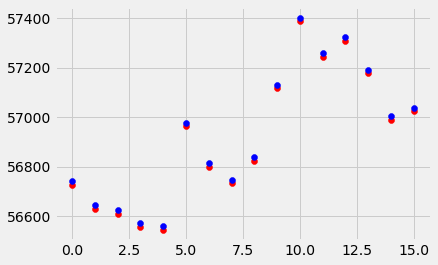

In [21]:
plt.scatter(price_results_df.index,price_results_df.actual_price, color='r', label='actual')
plt.scatter(price_results_df.index, price_results_df.previously_predicted_price, color='b', label='previous')
plt.show()

In [52]:
# for i in range(len(price_results_df)):
#     print(price_results_df.actual_price[i])
correlation = []
for i in range(len(price_results_df)):
    x=(abs(price_results_df.actual_price[i]-\
       price_results_df.previously_predicted_price[i]))/price_results_df.actual_price[i]
    correlation.append(x)

In [53]:
similarity_price = pd.DataFrame(correlation)
similarity_price.columns = ['Similarity_percentage']
similarity_price

,Similarity_percentage
0,0.000258
1,0.000262
2,0.000263
3,0.000266
4,0.000266
5,0.000248
6,0.000255
7,0.000258
8,0.000254
9,0.000241


In [24]:
price_results_df.corr()

,actual_price,predicted_price,previously_predicted_price
actual_price,1.0,1.0,1.0
predicted_price,1.0,1.0,1.0
previously_predicted_price,1.0,1.0,1.0


In [25]:
results_df.describe()

,predicted_price
count,16.000000
mean,56929.370537
std,275.720879
min,56561.082034
25%,56718.183839
50%,56908.356820
75%,57145.582268
max,57401.954973


In [26]:
price_results_df.actual_price.describe()

count       16.000000
mean     56915.140625
std        276.336365
min      56546.030000
25%      56703.482500
50%      56894.080000
75%      57131.835000
max      57388.780000
Name: actual_price, dtype: float64

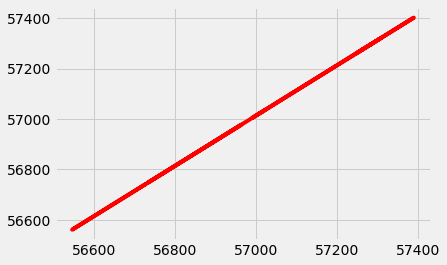

In [27]:
plt.plot(a_projection,Lreg_predict, color='r')

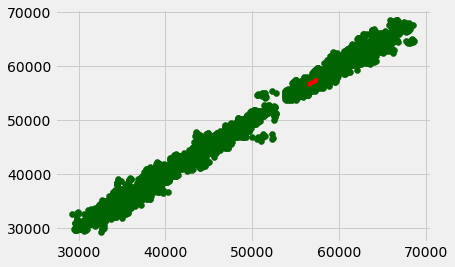

In [28]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## TI MACHINE L GRAPAHS

In [29]:
def TI_MachLearn_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.predicted_price.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.predicted_price.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k')
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r')
    plt.title('MACD graph next 16 periods')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')

   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 2 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['predicted_price'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['predicted_price'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['predicted_price','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['predicted_price'], color = 'k', label='closing price')
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA')
    ax.set_title('BBands next 16 periods')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()    

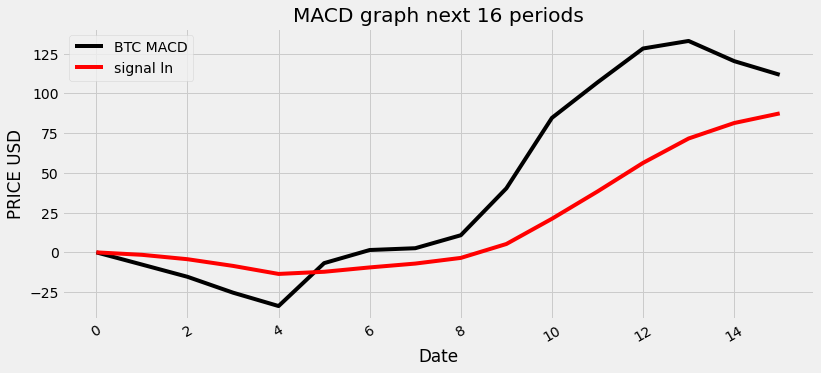

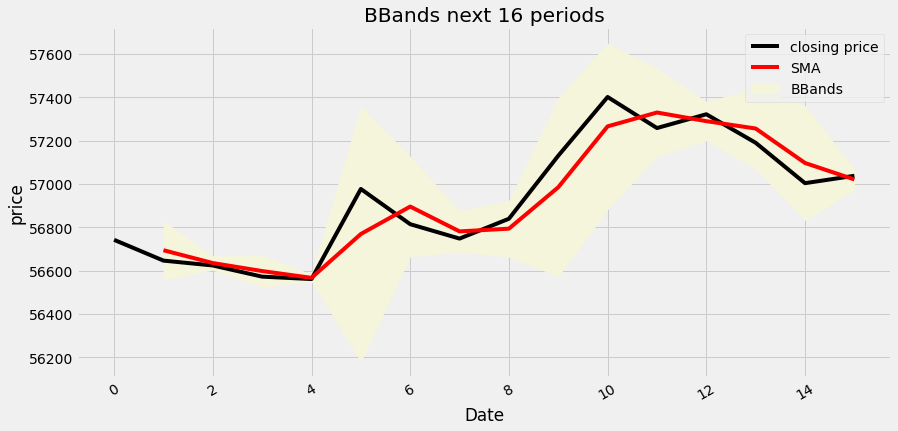

In [30]:
TI_MachLearn_graphs(results_df)

## macd machine learning notification

In [31]:
#buy sell signal
def alert_MACD_ML(signal):
    buy = []
    
    
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            
            if flag != 1:
                buy.append('1')
                
                flag = 1
            else:
                buy.append(np.nan)
                
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)

            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
                
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            
    return(buy, sell)
            

In [32]:
#Create DF for MACD
crypto_MACD_ML_df= results_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['S_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['L_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_ML_df['MACD_line']=\
                          crypto_MACD_ML_df.S_EMA-crypto_MACD_ML_df.L_EMA
#calculate Signal Line
crypto_MACD_ML_df['Sig_line']=\
                          crypto_MACD_ML_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_ML_df.tail(20)

,actual_price,predicted_price,S_EMA,L_EMA,MACD_line,Sig_line
0,[56727.53],56742.177778,56742.177778,56742.177778,0.000000,0.000000
1,[56631.34],56646.202023,56727.412277,56735.068463,-7.656186,-1.531237
2,[56608.82],56623.732181,56711.461493,56726.821331,-15.359838,-4.296957
3,[56557.1],56572.127378,56690.025475,56715.362520,-25.337044,-8.504975
4,[56546.03],56561.082034,56670.188023,56703.934335,-33.746313,-13.553242
5,[56963.03],56977.153248,56717.413442,56724.172773,-6.759331,-12.194460
6,[56799.99],56814.476388,56732.346203,56730.861930,1.484273,-9.458713
7,[56733.26],56747.895016,56734.738328,56732.123640,2.614688,-7.044033
8,[56825.13],56839.560393,56750.864800,56740.081918,10.782882,-3.478650
9,[57116.86],57130.640621,56809.291849,56769.012192,40.279657,5.273011


In [33]:
#create buy and sell columns in df
x = alert_MACD_ML(crypto_MACD_ML_df)
crypto_MACD_ML_df['ML_MACD_Buy_Notification'] = x[0]
crypto_MACD_ML_df['ML_MACD_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_ML_BuySell_Sig_df = crypto_MACD_ML_df[['ML_MACD_Buy_Notification',
                                                   'ML_MACD_Sell_Notification']]
crypto_MACD_ML_BuySell_Sig_df.fillna(0)

,ML_MACD_Buy_Notification,ML_MACD_Sell_Notification
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0
5,1,0
6,0,0
7,0,0
8,0,0
9,0,0


## ML MACD PREVIOUSLY

In [ ]:
#Create DF for MACD
P_crypto_MACD_ML_df= results_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
P_crypto_MACD_ML_df['S_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['L_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_ML_df['MACD_line']=\
                          crypto_MACD_ML_df.S_EMA-crypto_MACD_ML_df.L_EMA
#calculate Signal Line
crypto_MACD_ML_df['Sig_line']=\
                          crypto_MACD_ML_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_ML_df.tail(20)

In [ ]:
#create buy and sell columns in df
x = alert_MACD_ML(crypto_MACD_ML_df)
crypto_MACD_ML_df['ML_MACD_Buy_Notification'] = x[0]
crypto_MACD_ML_df['ML_MACD_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_ML_BuySell_Sig_df = crypto_MACD_ML_df[['ML_MACD_Buy_Notification',
                                                   'ML_MACD_Sell_Notification']]
crypto_MACD_ML_BuySell_Sig_df.fillna(0)

## BBand ML notification

In [34]:
crypto_ML_BBand_df = results_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 2

# calculate SMA
crypto_ML_BBand_df['SMA']=crypto_ML_BBand_df['predicted_price'].rolling(window = period).mean()
#calculate std
crypto_ML_BBand_df['STD']=crypto_ML_BBand_df['predicted_price'].rolling(window = period).std()
#calculate BB UP
crypto_ML_BBand_df['BBand Upper']=crypto_ML_BBand_df['SMA']+(crypto_ML_BBand_df['STD']*2)
#calculate BB LOW
crypto_ML_BBand_df['BBand Lower']=crypto_ML_BBand_df['SMA']-(crypto_ML_BBand_df['STD']*2)

crypto_ML_BBand_df.head()

,actual_price,predicted_price,SMA,STD,BBand Upper,BBand Lower
0,[56727.53],56742.177778,NaN,NaN,NaN,NaN
1,[56631.34],56646.202023,56694.189900,67.865108,56829.920115,56558.459685
2,[56608.82],56623.732181,56634.967102,15.888577,56666.744256,56603.189948
3,[56557.1],56572.127378,56597.929780,36.490107,56670.909993,56524.949566
4,[56546.03],56561.082034,56566.604706,7.810237,56582.225181,56550.984231


In [35]:
#buy sell signal
def alert_ML_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['predicted_price'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['predicted_price'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [36]:
#create buy and sell columns in df
x=alert_ML_BBands(crypto_ML_BBand_df)
crypto_ML_BBand_df['ML_BB_Buy_Notification'] = x[0]
crypto_ML_BBand_df['ML_BB_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_ML_BBand_BuySell_Sig_df = crypto_ML_BBand_df[['ML_BB_Buy_Notification',
                                                     'ML_BB_Sell_Notification']]
crypto_ML_BBand_BuySell_Sig_df.fillna(0)

,ML_BB_Buy_Notification,ML_BB_Sell_Notification
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


# Techincal indicators strategy

## MACD df

In [37]:
#Create DF for MACD
crypto_MACD_df= crypto_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_df['MACD_line']=\
                          crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
#calculate Signal Line
crypto_MACD_df['Sig_line']=\
                          crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_df.tail(20)


,Open,High,Low,Last,Volume,S_EMA,L_EMA,MACD_line,Sig_line
Date_and_Time,,,,,,,,,
2021-11-24 07:30:00-06:00,56606.82,56726.34,56004.59,56025.80,1476.24609,56519.510749,56661.879885,-142.369135,-118.889821
2021-11-24 08:00:00-06:00,56025.80,56350.00,55870.20,56088.52,1691.58298,56453.204480,56619.408782,-166.204302,-128.352717
2021-11-24 08:30:00-06:00,56088.52,56230.66,55837.00,56134.95,1197.01911,56404.242252,56583.522946,-179.280694,-138.538312
2021-11-24 09:00:00-06:00,56134.95,56480.00,56072.66,56292.99,1187.60108,56387.126521,56562.001987,-174.875466,-145.805743
2021-11-24 09:30:00-06:00,56292.99,57166.23,56292.99,56727.53,1823.50128,56439.496287,56574.263322,-134.767034,-143.598001
2021-11-24 10:00:00-06:00,56727.53,56866.75,56599.99,56631.34,954.35257,56469.010705,56578.491224,-109.480519,-136.774505
2021-11-24 10:30:00-06:00,56630.17,56767.00,56552.22,56608.82,636.58703,56490.519827,56580.737800,-90.217973,-127.463199
2021-11-24 11:00:00-06:00,56608.81,56776.42,56526.55,56557.10,592.77728,56500.762930,56578.986852,-78.223921,-117.615343
2021-11-24 11:30:00-06:00,56557.09,56637.00,56477.01,56546.03,603.79101,56507.727095,56576.545603,-68.818508,-107.855976


## MACD graph w Plotly to html

In [38]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')

fig = go.Figure()
fig.add_trace(go.Scatter(x=crypto_MACD_df.index, y=crypto_MACD_df['MACD_line'],
                        line=dict(color='blue',width = 1.5), name = 'MACD LN'))
fig.add_trace(go.Scatter(x=crypto_MACD_df.index, y=crypto_MACD_df['Sig_line'],
                        line=dict(color='red',width = 1.5), name = 'SIG LN'))


fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()
fig.write_html(f'{path}/MACD.html')

## MACD buy and sell notification

In [39]:
#buy sell signal
def alert_MACD(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [40]:
#create buy and sell columns in df
x = alert_MACD(crypto_MACD_df)
crypto_MACD_df['MACD_Buy_Notification'] = x[0]
crypto_MACD_df['MACD_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_BuySell_Sig_df = crypto_MACD_df[['MACD_Buy_Notification', 'MACD_Sell_Notification']][-16:]
crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False)

,MACD_Buy_Notification,MACD_Sell_Notification
Date_and_Time,,
2021-11-24 17:00:00-06:00,0,0
2021-11-24 16:30:00-06:00,0,0
2021-11-24 16:00:00-06:00,0,0
2021-11-24 15:30:00-06:00,0,0
2021-11-24 15:00:00-06:00,0,0
2021-11-24 14:30:00-06:00,0,0
2021-11-24 14:00:00-06:00,0,0
2021-11-24 13:30:00-06:00,0,0
2021-11-24 13:00:00-06:00,0,0


## BOLLINGER BANDS df

In [41]:
crypto_BBand_df =crypto_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
#calculate std
crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
#calculate BB UP
crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
#calculate BB LOW
crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

crypto_BBand_df.sort_index(ascending = False).head(32)

,Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
Date_and_Time,,,,,,,,,
2021-11-24 17:00:00-06:00,56989.84,57100.00,56973.00,57023.97,613.80133,56759.2255,405.828165,57570.881830,55947.569170
2021-11-24 16:30:00-06:00,57176.76,57193.40,56833.00,56989.83,649.85640,56738.3685,402.208897,57542.786294,55933.950706
2021-11-24 16:00:00-06:00,57308.82,57450.00,57099.17,57176.76,576.63674,56710.6780,403.048540,57516.775081,55904.580919
2021-11-24 15:30:00-06:00,57244.99,57434.30,57242.89,57308.82,598.75182,56683.3400,388.034424,57459.408849,55907.271151
2021-11-24 15:00:00-06:00,57388.78,57476.03,57180.00,57245.00,920.04422,56648.5805,359.115388,57366.811276,55930.349724
2021-11-24 14:30:00-06:00,57116.86,57429.00,56925.06,57388.78,1167.58777,56613.2095,331.018851,57275.247201,55951.171799
2021-11-24 14:00:00-06:00,56825.13,57184.22,56722.00,57116.86,831.40407,56565.1615,278.017755,57121.197010,56009.125990
2021-11-24 13:30:00-06:00,56733.27,56893.00,56679.90,56825.13,624.23852,56541.6590,247.070357,57035.799714,56047.518286
2021-11-24 13:00:00-06:00,56799.98,56870.01,56571.42,56733.26,575.47804,56534.5300,240.428289,57015.386577,56053.673423


## BBands graphs w plotly to html

In [42]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')

fig = go.Figure()
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['BBand Upper'],
                        line=dict(color='blue',width = 1.5), name = 'BBand Lower'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['BBand Lower'],
                        line=dict(color='blue',width = 1.5), name = 'BBand Lower'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['SMA'],
                        line=dict(color='black',width = 1.5), name = 'SMA'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['Last'],
                        line=dict(color='red',width = 1.5), name = 'Last'))

fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()
fig.write_html(f'{path}/BBands.html')

## BBand buy sell Notification

In [43]:
#buy sell signal
def alert_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['Last'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['Last'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [44]:
#create buy and sell columns in df
x=alert_BBands(crypto_BBand_df)
crypto_BBand_df['BB_Buy_Notification'] = x[0]
crypto_BBand_df['BB_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_BBand_BuySell_Sig_df = crypto_BBand_df[['BB_Buy_Notification', 'BB_Sell_Notification']][-16:]
crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False)

,BB_Buy_Notification,BB_Sell_Notification
Date_and_Time,,
2021-11-24 17:00:00-06:00,0,0
2021-11-24 16:30:00-06:00,0,0
2021-11-24 16:00:00-06:00,0,0
2021-11-24 15:30:00-06:00,0,0
2021-11-24 15:00:00-06:00,0,0
2021-11-24 14:30:00-06:00,1,0
2021-11-24 14:00:00-06:00,0,0
2021-11-24 13:30:00-06:00,0,0
2021-11-24 13:00:00-06:00,0,0


## TI-Buy&Sell-notification(MACD & BBand alert condition is equal)

In [45]:
def alert(df1,df2):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(df1)):
        if df1['BB_Buy_Notification'][i] == df2['MACD_Buy_Notification'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif df1['BB_Sell_Notification'][i]== df2['MACD_Sell_Notification'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)               
            

In [46]:
#create buy and sell columns in df
m=alert(crypto_BBand_df,crypto_MACD_df)
crypto_alert_df = crypto_df.copy(deep=True)
crypto_alert_df['Buy_Notification'] = m[0]
crypto_alert_df['Sell_Notification'] = m[1]

# create df with buy and sell info
crypto_alert_BuySell_Sig_df = crypto_alert_df[['Buy_Notification', 'Sell_Notification']]
crypto_alert_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(17)

,Buy_Notification,Sell_Notification
Date_and_Time,,
2021-11-24 17:00:00-06:00,0,0
2021-11-24 16:30:00-06:00,0,0
2021-11-24 16:00:00-06:00,0,0
2021-11-24 15:30:00-06:00,0,0
2021-11-24 15:00:00-06:00,0,0
2021-11-24 14:30:00-06:00,0,0
2021-11-24 14:00:00-06:00,0,0
2021-11-24 13:30:00-06:00,0,0
2021-11-24 13:00:00-06:00,0,0


In [47]:
crypto_buy_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Buy_Notification'] == 1]
crypto_buy_df

,Buy_Notification,Sell_Notification
Date_and_Time,,


In [48]:
crypto_sell_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Sell_Notification'] == 1]
crypto_sell_df

,Buy_Notification,Sell_Notification
Date_and_Time,,


In [49]:
crypto_df['Last'].describe()

count     8819.000000
mean     45950.697306
std      10509.431569
min      29238.990000
25%      36314.245000
50%      45268.230000
75%      55017.615000
max      68633.690000
Name: Last, dtype: float64

## Technical Indicators graphs

In [50]:
def TI_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r', linewidth=1)
    plt.title(f'MACD graph from previous {lookback}')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')
    
    # plt chart from previous day 
    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    plt.figure(figsize=(13, 4))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.9)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=0.7)
    plt.legend(loc='upper left')
    plt.xlim([Previous_Date, now])
    plt.title('MACD graph from previous day')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    # plt chart from previous hour
    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    plt.figure(figsize=(15, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=1)
    plt.legend(loc='upper left')
    plt.xlim([lastHour, now])
    plt.title('MACD graph from previous 8 hours')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    
    
   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 20 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.6)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=1.5)
    ax.set_title(f'BBands previous {lookback}')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS DAY
    fig = plt.figure(figsize = (13,5))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.7)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'lightcoral', label='SMA', linewidth=1.5)
    plt.xlim([Previous_Date,now])
    ax.set_title('BBands previous day')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS HOUR
    fig = plt.figure(figsize = (13,12))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.5)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=0.7)
    plt.xlim([lastHour, now])
    ax.set_title('BBands ')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.title('BBands last 8 hour')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()
    

AttributeError: 'str' object has no attribute 'today'

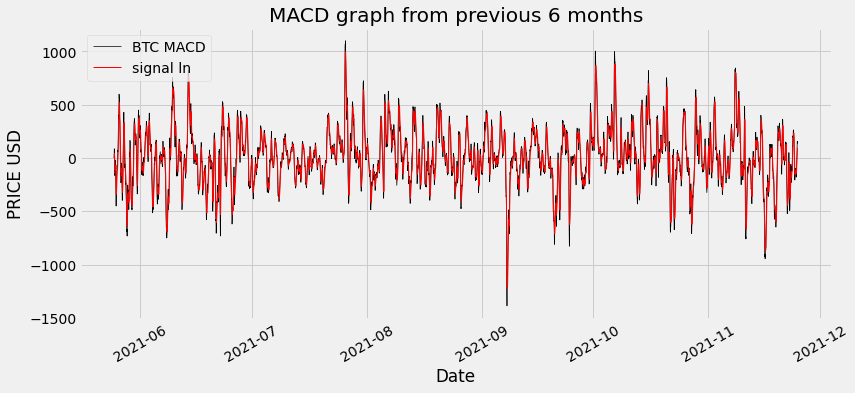

In [51]:
TI_graphs(crypto_df)

## BACKTESTING MACD

In [ ]:
# You cannot asume you will buy or sell exactly on the notification time, 
#but you can assume you will buy in the next time
Buy, Sell = [],[]
for i in range(2,len(crypto_MACD_df)):
    if crypto_MACD_df.MACD_line.iloc[i] > crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]< crypto_MACD_df.Sig_line.iloc[i-1]:
        Buy.append(i)
    elif crypto_MACD_df.MACD_line.iloc[i] < crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]> crypto_MACD_df.Sig_line.iloc[i-1]:
        Sell.append(i)

In [ ]:
realbuy = [i+1 for i in Buy]
realsell = [i+1 for i in Sell]
                                                                             

In [ ]:
buyprice = crypto_MACD_df.Open.iloc[realbuy]
buyprice


In [ ]:
sellprice =crypto_MACD_df.Open.iloc[realsell]
sellprice

In [ ]:
# to calculate profit, exclude initial and final buying or selling condition
if sellprice.index[0]<buyprice.index[0]:
    sellprice = sellprice.drop(sellprice.index[0])
elif buyprice.index[-1]>buyprice.index[-1]:
    buyprice = buyprice.drop(buyprice.index[-1])
    

In [ ]:
profitsrel = []
for i in range(len(sellprice)):
    profitsrel.append((sellprice[i]-buyprice[i])/buyprice[i])

In [ ]:
profits_df = pd.DataFrame(profitsrel)
profits_df.describe()


# recomendation after machine L and TI

In [54]:

df1=crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False)
df2=crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False)
recomendation_df1 = pd.concat([df1, df2], axis =1)
recomendation_df1=recomendation_df1.astype(float)
recomendation_df1

,MACD_Buy_Notification,MACD_Sell_Notification,BB_Buy_Notification,BB_Sell_Notification
Date_and_Time,,,,
2021-11-24 17:00:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 16:30:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 16:00:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 15:30:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 15:00:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 14:30:00-06:00,0.0,0.0,1.0,0.0
2021-11-24 14:00:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 13:30:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 13:00:00-06:00,0.0,0.0,0.0,0.0


In [56]:
df3=crypto_ML_BBand_BuySell_Sig_df.fillna(0)
df4=crypto_MACD_ML_BuySell_Sig_df.fillna(0)
df5 = price_results_df[['actual_price','previously_predicted_price']]
recomendation_df2 = pd.concat([df4,df3,df5, similarity_price], axis =1)
recomendation_df2

,ML_MACD_Buy_Notification,ML_MACD_Sell_Notification,ML_BB_Buy_Notification,ML_BB_Sell_Notification,actual_price,previously_predicted_price,Similarity_percentage
0,0,0,0.0,0.0,56727.53,56742.177778,0.000258
1,0,1,0.0,0.0,56631.34,56646.202023,0.000262
2,0,0,0.0,0.0,56608.82,56623.732181,0.000263
3,0,0,0.0,0.0,56557.10,56572.127378,0.000266
4,0,0,0.0,0.0,56546.03,56561.082034,0.000266
5,1,0,0.0,0.0,56963.03,56977.153248,0.000248
6,0,0,0.0,0.0,56799.99,56814.476388,0.000255
7,0,0,0.0,0.0,56733.26,56747.895016,0.000258
8,0,0,0.0,0.0,56825.13,56839.560393,0.000254
9,0,0,0.0,0.0,57116.86,57130.640621,0.000241
